<a href="https://colab.research.google.com/github/SofiNurul/SKRIPSI/blob/main/KAMUS_LEXICON_ANALISIS_SENTIMEN_ULASAN_PRODUK_PENGHILANG_BEKAS_LUKA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Library**

---




In [1]:
import pandas as pd
import re
import string
import nltk
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support

Mengunduh resource nltk yang diperlukan



In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# **Information Extraction (IE) & Information Retrieval (IR) : Import Dataset**

---



Muat dataset

In [3]:
# Memuat dataset
df = pd.read_csv('data_kotor.csv', encoding='MacRoman')
# Menampilkan 5 data teratas dan 5 data terakhir
df_combined = pd.concat([df.head(5), df.tail(5)], axis=0)
# Menampilkan hasil
df_combined

,username,date,content,score
0,z*****e,10/10/2024,Pertama kali coba karena baca ulasan di Quora ...,4
1,dindardew,03/09/2024,Penasaran bgt dari dulu udah laser jg bekas lu...,5
2,dikamungil,03/09/2024,"Udah ku pke beberapa kali sih, semoga bermanfa...",5
3,cakranouval,11/08/2024,"kecewa, kemasan penyok",3
4,ilhamansyari22,18/06/2024,Barang sesuai pesanan √¢Àú¬∫√Ø¬∏¬è,5
1169,Pengguna Shopee,10/10/2019,Bismillah semoga cocok guys. Ini sepertinya ha...,5
1170,faizarik22,09/10/2019,Masih mau nyobak sih. Soon mungkin 1 tahun ked...,5
1171,faratania,30/09/2019,Respon cepat. Produk superrrr bagusssss. Ini u...,5
1172,ayanara_,21/09/2019,"Ini seriusan pesen tanggal 20, trus tgl 21 uda...",5
1173,yuanrayi05,14/03/2019,Udh Beli 2x alhamdulillah Ada hasilnya Dan dpt...,5


# **Natural Language Processing (NLP)**

---




Pembersihan teks

In [4]:
# Fungsi untuk membersihkan teks
def clean_text(teks):
    if not isinstance(teks, str):
        return ""
    teks = teks.lower()
    teks = re.sub(r'http\S+|www\S+|https\S+', '', teks)  # Menghapus URL
    teks = re.sub(r'[^\x00-\x7F]+', ' ', teks)  # Menghilangkan karakter non-ASCII
    teks = teks.translate(str.maketrans('', '', string.punctuation))  # Menghapus tanda baca
    teks = re.sub(r'\d+', '', teks)  # Menghapus angka
    return teks

# Fungsi untuk tokenisasi
def tokenize(teks):
    return teks.split()

# Fungsi untuk menghapus stopwords
def remove_stopwords(tokens, stopwords_set):
    return [word for word in tokens if word not in stopwords_set]

# Fungsi untuk stemming
def apply_stemming(tokens, stemmer):
    return [stemmer.stem(token) for token in tokens]

# Fungsi untuk menjalankan semua tahapan preprocessing
def preprocess_text(teks, stopwords_set, stemmer):
    cleaned_text = clean_text(teks)               # Membersihkan teks
    tokens = tokenize(cleaned_text)               # Tokenisasi
    filtered_tokens = remove_stopwords(tokens, stopwords_set)  # Menghapus stopwords
    stemmed_tokens = apply_stemming(filtered_tokens, stemmer)  # Melakukan stemming
    return {
        "cleaned_text": cleaned_text,
        "tokens": tokens,
        "filtered_tokens": filtered_tokens,
        "stemmed_tokens": stemmed_tokens
    }

Inisialisasi Stopwords dan Stemmer

In [5]:
stopwords_tambahan = set([
    'gk', 'yg', 'nya', 'dan', 'dll', 'saja', 'juga', 'untuk', 'dengan', 'atau',
    'tapi', 'karena', 'seperti', 'yang', 'saya', 'ga', 'malah', 'tidak', 'lagi',
    'ini', 'di', 'kok', 'aja', 'gak', 'jadi', 'ya', 'dah', 'bisa', 'ada', 'bgt',
    'banget', 'kak', 'ituu', 'grgr', 'jd', 'pengen', 'dgn', 'udah', 'klo', 'tp',
    'pa', 'udh', 'karin', 'bgtt', 'ig', 'po', 'tau', 'utk', 'karna', 'brangnya',
    'ngk', 'kyk', 'sy', 'tp', 'uda', 'nga', 'dngn', 'kalo', 'gamau', 'becak', 'kya',
    'sma', 'jdi', 'ad', 'lg', 'pa', 'huhu', 'dpt', 'gel', 'b', 'jg', 'rb', 'hehe',
    'pdhl', 'dr', 'ku', 'sih', 'ka', 'kyk', 'sy', 'bli', 'skali', 'dikrim', 'berharap',
    'kirim', 'jdi', 'pkai', 'penjual', 'brangnya', 'becak', 'tpi', 'blum', 'bgin','aku','beli','ya','ini','ga','udah','di',
])
nltk_stopwords = set(stopwords.words('indonesian'))  # Mengambil stopwords dari NLTK
final_stopwords = nltk_stopwords.union(stopwords_tambahan)  # Menggabungkan stopwords NLTK dengan tambahan

# Membuat objek stemmer
!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.5 MB/s eta 0:00:00


Proses Preprocessing Data

In [6]:
df_selected = df[['content']]

# Terapkan preprocessing
processed_data = df_selected['content'].apply(
    lambda x: preprocess_text(x, final_stopwords, stemmer)
)

Tambahkan kolom hasil preprocessing ke DataFrame

In [7]:
# Menambahkan kolom ke DataFrame
df['cleaned_text'] = processed_data.apply(lambda x: x['cleaned_text'])
df['tokens'] = processed_data.apply(lambda x: x['tokens'])
df['filtered_tokens'] = processed_data.apply(lambda x: x['filtered_tokens'])
df['stemmed_tokens'] = processed_data.apply(lambda x: x['stemmed_tokens'])

# Mengatur tampilan Pandas agar teks ditampilkan penuh
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

# Menampilkan tabel hasil preprocessing (10 baris teratas)
df_subset = df[['content', 'cleaned_text', 'tokens', 'filtered_tokens', 'stemmed_tokens']].head(10)

# Menggunakan Pandas Styler untuk menampilkan tabel
styled_table = df_subset.style.set_properties(**{
    'text-align': 'left'  # Atur teks agar rata kiri
}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'left')]  # Atur header kolom agar rata kiri
}])

# Tampilkan tabel
from IPython.display import display
display(styled_table)

,content,cleaned_text,tokens,filtered_tokens,stemmed_tokens
0,"Pertama kali coba karena baca ulasan di Quora katanya bagus, semoga ngefek bekas2 korengan pas hamil anak ke 2 memudar, hasilnya pemakaian 1 botol insyaallah akan aku update ya.. kalo emang bagus pasti repurchase (beli lagi) di toko ini, Sellernya ramah dan amanah.. suka kalo di chat gercep di balas gak pake lama, pengiriman ke Jakarta juga cepat.",pertama kali coba karena baca ulasan di quora katanya bagus semoga ngefek bekas korengan pas hamil anak ke memudar hasilnya pemakaian botol insyaallah akan aku update ya kalo emang bagus pasti repurchase beli lagi di toko ini sellernya ramah dan amanah suka kalo di chat gercep di balas gak pake lama pengiriman ke jakarta juga cepat,"['pertama', 'kali', 'coba', 'karena', 'baca', 'ulasan', 'di', 'quora', 'katanya', 'bagus', 'semoga', 'ngefek', 'bekas', 'korengan', 'pas', 'hamil', 'anak', 'ke', 'memudar', 'hasilnya', 'pemakaian', 'botol', 'insyaallah', 'akan', 'aku', 'update', 'ya', 'kalo', 'emang', 'bagus', 'pasti', 'repurchase', 'beli', 'lagi', 'di', 'toko', 'ini', 'sellernya', 'ramah', 'dan', 'amanah', 'suka', 'kalo', 'di', 'chat', 'gercep', 'di', 'balas', 'gak', 'pake', 'lama', 'pengiriman', 'ke', 'jakarta', 'juga', 'cepat']","['kali', 'coba', 'baca', 'ulasan', 'quora', 'bagus', 'semoga', 'ngefek', 'bekas', 'korengan', 'pas', 'hamil', 'anak', 'memudar', 'hasilnya', 'pemakaian', 'botol', 'insyaallah', 'update', 'emang', 'bagus', 'repurchase', 'toko', 'sellernya', 'ramah', 'amanah', 'suka', 'chat', 'gercep', 'balas', 'pake', 'pengiriman', 'jakarta', 'cepat']","['kali', 'coba', 'baca', 'ulas', 'quora', 'bagus', 'moga', 'ngefek', 'bekas', 'koreng', 'pas', 'hamil', 'anak', 'pudar', 'hasil', 'pakai', 'botol', 'insyaallah', 'update', 'emang', 'bagus', 'repurchase', 'toko', 'sellernya', 'ramah', 'amanah', 'suka', 'chat', 'gercep', 'balas', 'pake', 'kirim', 'jakarta', 'cepat']"
1,Penasaran bgt dari dulu udah laser jg bekas luka gak ilang Nemu produk ini jadi coba aja dulu siapa tau cocok order 2 langsung kk,penasaran bgt dari dulu udah laser jg bekas luka gak ilang nemu produk ini jadi coba aja dulu siapa tau cocok order langsung kk,"['penasaran', 'bgt', 'dari', 'dulu', 'udah', 'laser', 'jg', 'bekas', 'luka', 'gak', 'ilang', 'nemu', 'produk', 'ini', 'jadi', 'coba', 'aja', 'dulu', 'siapa', 'tau', 'cocok', 'order', 'langsung', 'kk']","['penasaran', 'laser', 'bekas', 'luka', 'ilang', 'nemu', 'produk', 'coba', 'cocok', 'order', 'langsung', 'kk']","['penasaran', 'laser', 'bekas', 'luka', 'ilang', 'nemu', 'produk', 'coba', 'cocok', 'order', 'langsung', 'kk']"
2,"Udah ku pke beberapa kali sih, semoga bermanfaat. Makasih ya seller. Harganya mahal tp semoga ampuuuuh yaaaa",udah ku pke beberapa kali sih semoga bermanfaat makasih ya seller harganya mahal tp semoga ampuuuuh yaaaa,"['udah', 'ku', 'pke', 'beberapa', 'kali', 'sih', 'semoga', 'bermanfaat', 'makasih', 'ya', 'seller', 'harganya', 'mahal', 'tp', 'semoga', 'ampuuuuh', 'yaaaa']","['pke', 'kali', 'semoga', 'bermanfaat', 'makasih', 'seller', 'harganya', 'mahal', 'semoga', 'ampuuuuh', 'yaaaa']","['pke', 'kali', 'moga', 'manfaat', 'makasih', 'seller', 'harga', 'mahal', 'moga', 'ampuuuuh', 'yaaaa']"
3,"kecewa, kemasan penyok",kecewa kemasan penyok,"['kecewa', 'kemasan', 'penyok']","['kecewa', 'kemasan', 'penyok']","['kecewa', 'kemas', 'penyok']"
4,Barang sesuai pesanan √¢Àú¬∫√Ø¬∏¬è,barang sesuai pesanan,"['barang', 'sesuai', 'pesanan']","['barang', 'sesuai', 'pesanan']","['barang', 'sesuai', 'pesan']"
5,Baru pertama kali coba mudah mudahan bisa pudar bekas keloid nya Maksih semoga berkah Kalau cocok bakal beli lagi Maaf ya kk fotonya gak sesuai,baru pertama kali coba mudah mudahan bisa pudar bekas keloid nya maksih semoga berkah kalau cocok bakal beli lagi maaf ya kk fotonya gak sesuai,"['baru', 'pertama', 'kali', 'coba', 'mudah', 'mudahan', 'bisa', 'pudar', 'bekas', 'keloid', 'nya', 'maksih', 'semoga', 'berkah', 'kalau', 'cocok', 'bakal', 'beli', 'lagi', 'maaf', 'ya', 'kk', 'fotonya', '

In [8]:
import os

# Simpan hasil preprocessing ke file CSV
output_file = "hasil_preprocessing.csv"
df_selected.to_csv(output_file, index=False)

print(f"Hasil preprocessing telah disimpan ke file: {os.path.abspath(output_file)}")

Hasil preprocessing telah disimpan ke file: /content/hasil_preprocessing.csv


# **CLUSTERING**

---



Tranformasi Data Menjadi Fitur Numerik


=== Hasil Klasifikasi Sentimen (Skor 0 atau Lebih Menjadi Positif) ===
|    | stemmed_tokens                                                                                                                                                                                                                                                                                                              |   polarity_score | sentiment   |
|---:|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------------:|:------------|
|  0 | ['kali', 'coba', 'baca', 'ulas', 'quora', 'bagus', 'moga', 'ngefek', 'bekas', 'koreng', 'pas', 'hamil', 'anak', 'pudar', 'hasil', 'pakai', 'botol', 'insyaallah', 'update', 'emang', 'bagus', 'repurchase', '

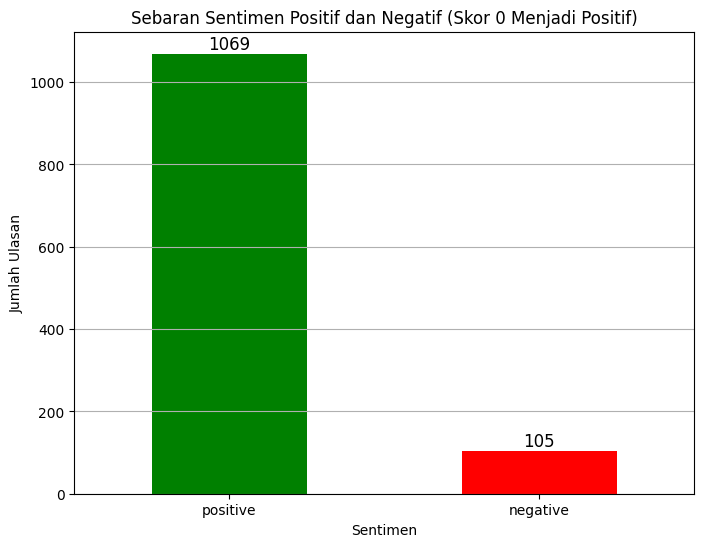

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load kamus sentimen positif dan negatif, abaikan baris header jika ada
positive_words = pd.read_csv('/content/positive.tsv', sep='\t', header=0, names=['word', 'weight'])
negative_words = pd.read_csv('/content/negative.tsv', sep='\t', header=0, names=['word', 'weight'])

# Bersihkan data: pastikan kolom 'weight' hanya berisi angka
positive_words = positive_words[pd.to_numeric(positive_words['weight'], errors='coerce').notnull()]
negative_words = negative_words[pd.to_numeric(negative_words['weight'], errors='coerce').notnull()]

# Konversi kolom 'weight' menjadi float
positive_words['weight'] = positive_words['weight'].astype(float)
negative_words['weight'] = negative_words['weight'].astype(float)

# Buat kamus (dictionary) dari data yang telah di-clean
positive_dict = dict(zip(positive_words['word'].str.strip(), positive_words['weight']))
negative_dict = dict(zip(negative_words['word'].str.strip(), negative_words['weight']))

# Fungsi untuk menghitung skor polaritas
def calculate_polarity_score(words):
    score = 0
    for word in words:  # Iterasi langsung pada setiap kata dalam daftar
        if word in positive_dict:
            score += positive_dict[word]  # Tambahkan bobot dari kamus positif
        elif word in negative_dict:
            score += negative_dict[word]  # Tambahkan bobot dari kamus negatif
    return score

# Fungsi untuk memberi label sentimen berdasarkan skor polaritas
def label_sentiment(score):
    if score >= 0:  # Skor 0 atau lebih besar dianggap positif
        return 'positive'
    else:  # Skor kurang dari 0 dianggap negatif
        return 'negative'

# Terapkan fungsi pada kolom komentar yang sudah di-preprocessing (stemmed_tokens)
df['polarity_score'] = df['stemmed_tokens'].apply(calculate_polarity_score)
df['sentiment'] = df['polarity_score'].apply(label_sentiment)

# Menampilkan hasil
print("\n=== Hasil Klasifikasi Sentimen (Skor 0 atau Lebih Menjadi Positif) ===")
print(df[['stemmed_tokens', 'polarity_score', 'sentiment']].head(10).to_markdown())

# Visualisasi sebaran sentimen
sentiment_counts = df['sentiment'].value_counts()

plt.figure(figsize=(8, 6))
ax = sentiment_counts.plot(kind='bar', color=['green', 'red'])

# Menambahkan angka di atas batang
for idx, value in enumerate(sentiment_counts):
    plt.text(idx, value + 1, str(value), ha='center', va='bottom', fontsize=12)

plt.title("Sebaran Sentimen Positif dan Negatif (Skor 0 Menjadi Positif)")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah Ulasan")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


# **Categorization : Klasifikasi Algortima Naive Bayes**

---



In [11]:
# Gabungkan token menjadi string sebelum TF-IDF
df['processed_text'] = df['stemmed_tokens'].apply(lambda tokens: ' '.join(tokens))

# Transformasi teks menjadi TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1200)  # Atur jumlah fitur sesuai kebutuhan
X = tfidf_vectorizer.fit_transform(df['processed_text'])

# Tampilkan 5 ulasan teratas setelah transformasi TF-IDF
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(X.toarray(), columns=tfidf_feature_names)

print("=== 5 Ulasan Teratas Setelah Transformasi TF-IDF ===")
print(tfidf_df.head(5))


=== 5 Ulasan Teratas Setelah Transformasi TF-IDF ===
   aamiin  aamin  abis  adain  adakan  adha  admin  adminnya  after  afternya  ...  yeyyy  ygy  you  youu  youuu  youuuuuuuuu  yra  yuhuu  yuk  zonk
0     0.0    0.0   0.0    0.0     0.0   0.0    0.0       0.0    0.0       0.0  ...    0.0  0.0  0.0   0.0    0.0          0.0  0.0    0.0  0.0   0.0
1     0.0    0.0   0.0    0.0     0.0   0.0    0.0       0.0    0.0       0.0  ...    0.0  0.0  0.0   0.0    0.0          0.0  0.0    0.0  0.0   0.0
2     0.0    0.0   0.0    0.0     0.0   0.0    0.0       0.0    0.0       0.0  ...    0.0  0.0  0.0   0.0    0.0          0.0  0.0    0.0  0.0   0.0
3     0.0    0.0   0.0    0.0     0.0   0.0    0.0       0.0    0.0       0.0  ...    0.0  0.0  0.0   0.0    0.0          0.0  0.0    0.0  0.0   0.0
4     0.0    0.0   0.0    0.0     0.0   0.0    0.0       0.0    0.0       0.0  ...    0.0  0.0  0.0   0.0    0.0          0.0  0.0    0.0  0.0   0.0

[5 rows x 1200 columns]


Evaluasi Model

In [12]:
# Target adalah label sentimen hasil klustering
y = df['sentiment']

# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# === GridSearchCV untuk Optimasi Model Naive Bayes ===

# Definisikan parameter yang ingin dicari
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]  # Nilai smoothing untuk MultinomialNB
}

# Inisialisasi model Naive Bayes
nb_model = MultinomialNB()

# GridSearchCV untuk mencari parameter terbaik
grid_search = GridSearchCV(estimator=nb_model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Menampilkan parameter terbaik
best_params = grid_search.best_params_
print(f"\n=== Parameter Terbaik: {best_params} ===")

# Menggunakan model terbaik untuk prediksi
best_nb_model = grid_search.best_estimator_
y_pred = best_nb_model.predict(X_test)

# Evaluasi model
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"\n=== Akurasi Model Setelah Optimasi: {accuracy:.2f} ===")



=== Parameter Terbaik: {'alpha': 0.1} ===

=== Classification Report ===
              precision    recall  f1-score   support

    negative       0.83      0.24      0.37        21
    positive       0.93      1.00      0.96       214

    accuracy                           0.93       235
   macro avg       0.88      0.62      0.67       235
weighted avg       0.92      0.93      0.91       235


=== Akurasi Model Setelah Optimasi: 0.93 ===


# **Visualization**

---



Confusion Matrix

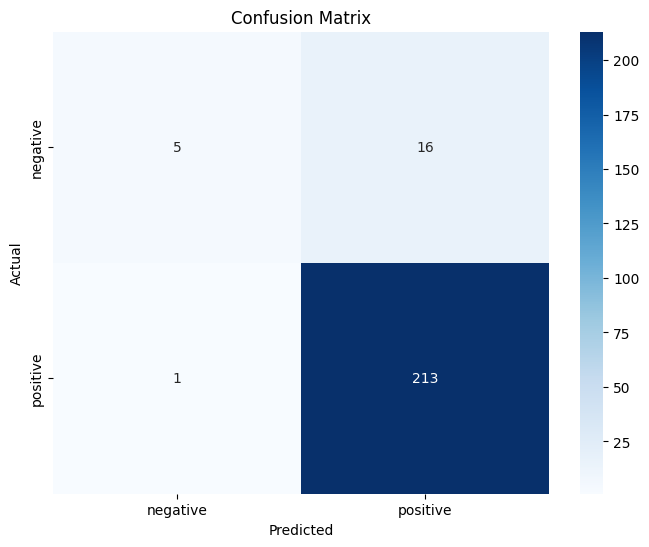

In [13]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Tampilkan Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_nb_model.classes_, yticklabels=best_nb_model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

WORDCLOUD UNTUK SETIAP SENTIMEN

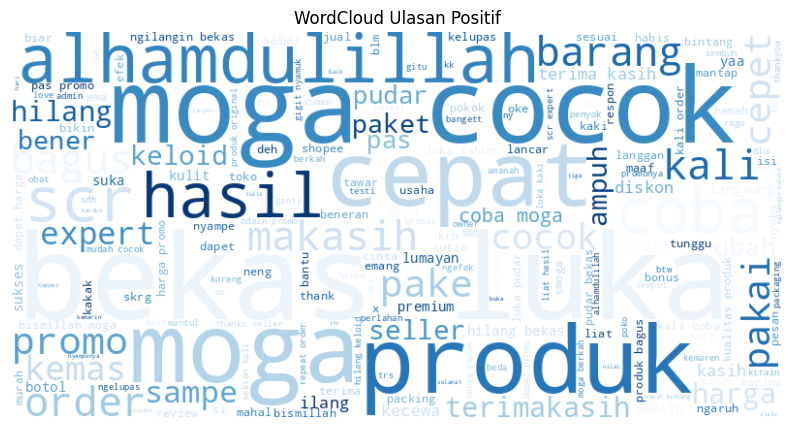

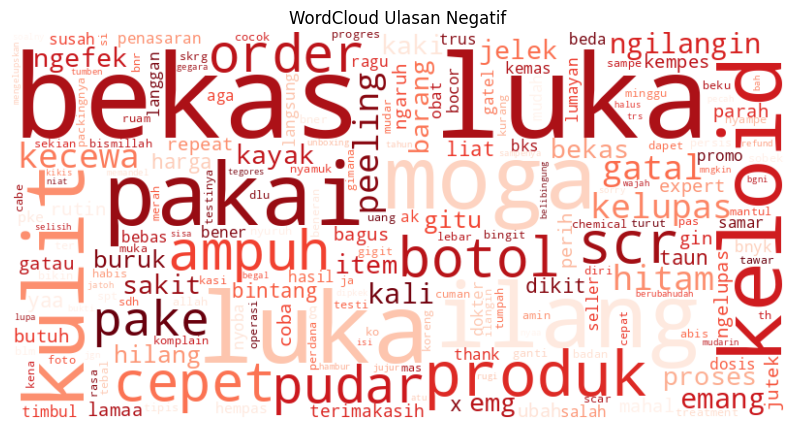

In [14]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Tambahkan stopwords tambahan jika diperlukan
custom_stopwords = STOPWORDS.union({
    'gk', 'yg', 'nya', 'dan', 'dll', 'saja', 'juga', 'untuk', 'dengan', 'atau',
    'tapi', 'karena', 'seperti', 'yang', 'saya', 'ga', 'malah', 'tidak', 'lagi',
    'ini', 'di', 'kok', 'aja', 'gak', 'jadi', 'ya', 'dah', 'bisa', 'ada', 'bgt',
    'banget', 'kak', 'ituu', 'grgr', 'jd', 'pengen', 'dgn', 'udah', 'klo', 'tp',
    'pa', 'udh', 'karin', 'bgtt', 'ig', 'po', 'tau', 'utk', 'karna', 'brangnya',
    'ngk', 'kyk', 'sy', 'tp', 'uda', 'nga', 'dngn', 'kalo', 'gamau', 'becak', 'kya',
    'sma', 'jdi', 'ad', 'lg', 'pa', 'huhu', 'dpt', 'gel', 'b', 'jg', 'rb', 'hehe',
    'pdhl', 'dr', 'ku', 'sih', 'ka', 'kyk', 'sy', 'bli', 'skali', 'dikrim', 'berharap',
    'kirim', 'jdi', 'pkai', 'penjual', 'brangnya', 'becak', 'tpi', 'blum', 'bgin','aku','beli','ya','ini','ga','udah','di',
})

# Gabungkan teks untuk sentimen positif
positive_text = " ".join(df[df['sentiment'] == 'positive']['processed_text'])

# Gabungkan teks untuk sentimen negatif
negative_text = " ".join(df[df['sentiment'] == 'negative']['processed_text'])

# Buat WordCloud untuk ulasan positif
positive_wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=custom_stopwords,
    colormap='Blues'  # Skema warna untuk positif
).generate(positive_text)

# Buat WordCloud untuk ulasan negatif
negative_wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=custom_stopwords,
    colormap='Reds'  # Skema warna untuk negatif
).generate(negative_text)

# Plot WordCloud untuk positif
plt.figure(figsize=(10, 6))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud Ulasan Positif")
plt.show()

# Plot WordCloud untuk negatif
plt.figure(figsize=(10, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud Ulasan Negatif")
plt.show()
